In [ ]:
!pip install plotly-express

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
import sys
np.set_printoptions(threshold=sys.maxsize, suppress=True, formatter={'float_kind':'{:0.6f}'.format})
import random
import csv
from math import exp, ceil, pi
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import ShuffleSplit
from sklearn.calibration import calibration_curve
import statistics
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import plotly_express as px

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

Conformal Prediction for Regression Sample 1 with California Housing Data set

##Manual Implementation of ICP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [ ]:
def loaddata(train, calib, test, name):
  print("Laoding {} Data".format(name))
  train_preds = np.genfromtxt(train, delimiter=',')
  calib_preds = np.genfromtxt(calib, delimiter=',')
  test_preds = np.genfromtxt(test, delimiter=',')
  print("No. of instances in Training set - {}".format(len(train_preds)))
  print("No. of instances in Calibration set - {}".format(len(calib_preds)))
  print("No. of instances in Test set - {}".format(len(test_preds)))
  return train_preds, calib_preds, test_preds


In [ ]:
train_preds_mscn, calib_preds_mscn, test_preds_mscn = loaddata(
    'basic_mscn_predictions_job-lighttrain_normalised.csv',
    'basic_mscn_predictions_job-light_calib_normalised.csv',
    'basic_mscn_predictions_job-light_test_changed.csv',
    'MSCN')
train_preds_Naru, calib_preds_Naru, test_preds_Naru = loaddata(
    'basic_naru_train.csv',
    'basic_naru_calib.csv',
    'basic_naru_test.csv',
    'NARU')
train_preds_mscn_bayes, calib_preds_mscn_bayes, test_preds_mscn_bayes = loaddata(
    'mscn_bayes_train.csv',
    'mscn_bayes_calib.csv',
    'mscn_bayes_test.csv',
    'MSCN_BNN')


Laoding MSCN Data
No. of instances in Training set - 9000
No. of instances in Calibration set - 1000
No. of instances in Test set - 70
Laoding NARU Data
No. of instances in Training set - 9000
No. of instances in Calibration set - 1000
No. of instances in Test set - 70
Laoding MSCN_BNN Data
No. of instances in Training set - 9000
No. of instances in Calibration set - 1000
No. of instances in Test set - 70


In [ ]:
def computeConformityScores(pred, y):
    res = np.abs(y - pred)
    return res

# Compute confidence intervals
def computeInterval(confScore, testPred, significance):
    if confScore is None:
        sys.exit("\n NULL model \n")
    confScore = np.sort(confScore)
    nrTestCases  = len(testPred)
    intervals = np.zeros((nrTestCases, 2))
    interval_size = np.zeros(nrTestCases)
    lower = np.zeros((nrTestCases, 1))
    upper = np.zeros((nrTestCases, 1))
    mid = np.zeros((nrTestCases, 1)) #intervals of size 2

    for k in range(0, nrTestCases):
        # Compute threshold for conformal, at significance level.
        n = len(confScore)

        if (ceil((n) * significance) <= 1):
            q = np.inf
        else:
            q= (confScore[ceil((n) * (1 - significance))])
        intervals[k, 0] = testPred[k] - q
        intervals[k, 1] = testPred[k] + q
        interval_size[k] = intervals[k, 1] - intervals[k, 0]
        lower[k] = intervals[k, 0]
        upper[k] = intervals[k, 1]
        mid[k] = statistics.median([lower[k], upper[k]])
    return intervals, interval_size, lower, mid, upper

In [ ]:
# Computes efficiency of a conformal predictor, average width of the intervals
def Efficiency(intervals):
    nrTestCases = len(intervals)
    mean_width = np.mean(abs(intervals[:,0]-intervals[:,1]))
    return mean_width

#Coverage check
def ErrorRate(intervals, testLabels):
    if (intervals is None) or (testLabels is None):
        sys.exit("\n NULL values for input parameters \n")
    nrTestCases = len(testLabels)
    err = 0
    coverage = 0
    for j in range(0, nrTestCases):
        if (intervals[j, 0] > testLabels[j]) or \
                (intervals[j, 1] < testLabels[j]):
            err = err + 1
    coverage = nrTestCases - err
    err = err / nrTestCases #normalizing
    return err, coverage

#Computes performance measures: efficiency and validity of the conformal predictors
def pValues2PerfMetrics(intervals, testLabels):
  mean_width = Efficiency(intervals)
  errRate, coverage = ErrorRate(intervals, testLabels)
  return mean_width, errRate, coverage

def combine_intervals(intervals):
    low = np.min(intervals[:,0], axis=0)
    high = np.max(intervals[:,1],axis=0)
    return np.column_stack((low, high))

# compute median width and median center point
def compute_median(intervals):
    width = np.median( np.abs(intervals[:,0] - intervals[:,1]), axis=0)
    median = np.median((intervals[:, 1] + intervals[:, 0])/2, axis=0)
    low = median - width/2
    high = median + width / 2
    return np.column_stack((low, high))

# compute means of the lower and upper bounds
def aggregateIntervals(intervals):
    low = np.median( intervals[ : ,0], axis=0)
    high = np.median(intervals[ :, 1], axis=0)
    return np.column_stack((low, high))

In [ ]:
def calibration_plot(sigLevels, errors):
  plt.title('Conformal Calibration Curve')
  plt.xlim((0, 1))
  plt.ylim((0, 1))
  plt.plot(sigLevels, errors, label="Errors")
  plt.plot([0,1], [0,1], "k:", label="Ideal")
  plt.legend(loc = 'upper left')
  plt.xlabel('Significance Levels')
  plt.ylabel('Error rate')
  plt.show()


In [ ]:
def width_plot(sigLevels, avg_width):
  plt.title('Conformal Mean Interval Width Curve')
  plt.plot(sigLevels, avg_width, ls="-")
  plt.xlabel('Significance Levels')
  plt.ylabel('Average Interval Width')
  plt.show()

In [ ]:
def median_plot(median_width):
  print(median_width)
  fig = plt.figure(figsize =(10, 7))
  plt.boxplot(median_width)
  plt.show()

In [ ]:
def final_plot(intervals, predictions):
  x1 = np.sort(intervals[:,0])
  x2 = np.sort(intervals[:,1])
  plt.plot(x1,"--", color="cyan", label="Lower Interval")
  plt.plot(x2,"--", color="cyan", label="Upper Interval")
  plt.plot(np.sort(test_preds_mscn[:,1]),color="red", lw=1, label="True Value")
  plt.legend(loc = 'upper left')
  plt.savefig('fig1.png', dpi = 300)
  plt.show()

In [ ]:
from pandas._libs.hashtable import value_count
def compare(y_test, testPred, lower, mid, upper):
    results = pd.DataFrame()
    results['True'] = y_test
    results['Predicted'] = testPred
    results['Lower'] = lower
    results['Mid'] = mid
    results["Upper"] = upper
    results['In_bounds'] = results['True'].between(left=results['Lower'], right=results['Upper'])
    coverage = (results['In_bounds'].value_counts(normalize=True).mul(100).astype(str)+'%')
    return results

In [ ]:
def calculate_error(prediction):
    """
    Calculate the absolute error associated with prediction intervals

    :param predictions: dataframe of predictions
    :return: None, modifies the prediction dataframe

    """
    new = pd.DataFrame()
    new['True'] = prediction['True']
    new['abs_err_l'] = (prediction['Lower'] - prediction['True']).abs()
    new['abs_err_u'] = (prediction['Upper'] - prediction['True']).abs()
    new['abs_err_m'] = (prediction['Mid'] - prediction['True']).abs()

    new['abs_err_int'] = (new['abs_err_l'] + new['abs_err_u']) / 2

    new['In_bounds'] = prediction['True'].between(left=prediction['Lower'], right=prediction['Upper'])
    return (new)

In [ ]:
def show_metrics(metrics):
    """
    Make a boxplot of the metrics associated with prediction intervals

    :param metrics: dataframe of metrics produced from calculate error
    :return fig: plotly figure
    """
    percent_in_bounds = metrics['In_bounds'].mean() * 100
    metrics_to_plot = metrics[[c for c in metrics if 'abs_err' in c]]

    # Rename the columns
    metrics_to_plot.columns = [column.split('_')[-1].title() for column in metrics_to_plot]

    # Create a boxplot of the metrics
    fig = px.box(
        metrics_to_plot.melt(var_name="metric", value_name='Absolute Error'),
        x="metric",
        y="Absolute Error",
        color='metric',
        title=f"Error Metrics Boxplots    In Bounds = {percent_in_bounds:.2f}%",
        height=800,
        width=1000,
        points=False,
    )

    # Create new data with no legends
    d = []

    for trace in fig.data:
        # Remove legend for each trace
        trace['showlegend'] = False
        d.append(trace)

    # Make the plot look a little better
    fig.data = d
    fig['layout']['font'] = dict(size=20)
    configure_plotly_browser_state()
    return fig

In [ ]:
def ConformalPrediction(train_preds, calib_preds, test_preds, key):
  nrTrainCases = len(train_preds)
  meanCalibPred = np.zeros(len(calib_preds))
  meanTestPred = np.zeros(len(test_preds))

  meanCalibPred = np.add(meanCalibPred, calib_preds[:,0])
  meanTestPred = np.add(meanTestPred, test_preds[:,0])
  sigLevels = np.linspace(0.01, .99, 100)
  # sigLevels = [0.05] #comment this line for ensemble run
  errorRate = np.zeros(len(sigLevels))
  interval_sizes = []
  interval_range=[]
  median_range=[]
  errors = []
  mean_width_all = []
  median_width = []
  for i in range(len(sigLevels)):
        confScores = computeConformityScores(meanCalibPred,
                                             calib_preds[:,1])
        intervals, interval_size, lower, mid, upper = computeInterval(
            confScores, meanTestPred, sigLevels[i]
            )
        range_interval = combine_intervals(intervals)
        median_interval = compute_median(intervals)
        med_width = np.abs(median_interval[0][0] - median_interval[0][1])
        median_width.append(med_width)
        interval_range.append(range_interval)
        median_range.append(median_interval)
        mean_width, errorRate, coverage = pValues2PerfMetrics(
            intervals, test_preds[:,1]
            )
        errors.append(errorRate)
        mean_width_all.append(mean_width)
        if round(sigLevels[i],2) in (0.01, 0.05, 0.1):
          print("---------------Significance - {}-----------------".format(round(sigLevels[i],2)))
          # df = pd.DataFrame(
          #     np.c_[intervals, test_preds[:,1], test_preds[:,0]],
          #     columns=['Lower Interval','Upper Interval','True Labels','Predictions'])
          # print(df)
          box_plot_preds = compare(test_preds[:,1],
                                   test_preds[:,0],
                                   lower, mid, upper)
          print(box_plot_preds)
          metrics = calculate_error(box_plot_preds)
          # iplot(show_metrics(metrics))
          print("Average Interval Width - {0:.2f}".format(mean_width))
          print("Median Width - {}".format(median_range[i]))
          print("Coverage - {}".format(coverage))
          print("Error rate - {0:.2f}".format(errorRate))
          print("Coverage rate - {0:.2f}".format(1-errorRate))
          print("------------------------------------------------")
          final_plot(intervals, test_preds[:,0])

  calibration_plot(sigLevels, errors)
  width_plot(sigLevels, mean_width_all)
  median_plot(median_width)
  return intervals, coverage


###Predicting the Conformal Intervals at all Significance Levels

------------------Passing MSCN Data----------------------------
---------------Significance - 0.01-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.244132  0.019040  0.244132  0.469224       True
1   0.000000   0.135995 -0.089097  0.135995  0.361087       True
2   0.079539   0.130548 -0.094544  0.130548  0.355640       True
3   0.027687   0.196263 -0.028829  0.196263  0.421356       True
4   0.467319   0.592431  0.367339  0.592431  0.817523       True
5   0.758201   0.819866  0.594774  0.819866  1.044958       True
6   0.678612   0.798273  0.573181  0.798273  1.023365       True
7   0.802396   0.860226  0.635133  0.860226  1.085318       True
8   0.551293   0.627211  0.402118  0.627211  0.852303       True
9   0.476456   0.600282  0.375190  0.600282  0.825374       True
10  0.593186   0.672468  0.447376  0.672468  0.897560       True
11  0.647900   0.769375  0.544283  0.769375  0.994467       True
12  0.590756   0.741885  0.516793  0.74

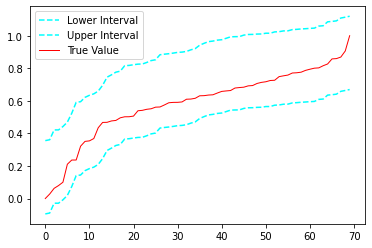

---------------Significance - 0.05-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.244132  0.103770  0.244132  0.384494       True
1   0.000000   0.135995 -0.004367  0.135995  0.276357       True
2   0.079539   0.130548 -0.009814  0.130548  0.270910       True
3   0.027687   0.196263  0.055901  0.196263  0.336625      False
4   0.467319   0.592431  0.452069  0.592431  0.732793       True
5   0.758201   0.819866  0.679504  0.819866  0.960228       True
6   0.678612   0.798273  0.657911  0.798273  0.938635       True
7   0.802396   0.860226  0.719864  0.860226  1.000588       True
8   0.551293   0.627211  0.486848  0.627211  0.767573       True
9   0.476456   0.600282  0.459920  0.600282  0.740644       True
10  0.593186   0.672468  0.532106  0.672468  0.812830       True
11  0.647900   0.769375  0.629013  0.769375  0.909737       True
12  0.590756   0.741885  0.601523  0.741885  0.882247      False
13  0.681524   0.812274  0.671912  0.8

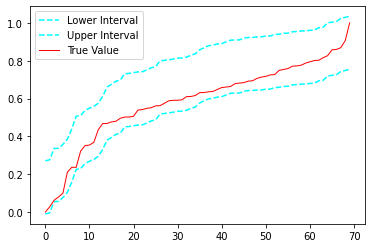

---------------Significance - 0.1-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.244132  0.156104  0.244132  0.332160       True
1   0.000000   0.135995  0.047967  0.135995  0.224023      False
2   0.079539   0.130548  0.042520  0.130548  0.218576       True
3   0.027687   0.196263  0.108235  0.196263  0.284291      False
4   0.467319   0.592431  0.504403  0.592431  0.680459      False
5   0.758201   0.819866  0.731838  0.819866  0.907894       True
6   0.678612   0.798273  0.710245  0.798273  0.886301      False
7   0.802396   0.860226  0.772198  0.860226  0.948254       True
8   0.551293   0.627211  0.539183  0.627211  0.715239       True
9   0.476456   0.600282  0.512254  0.600282  0.688310      False
10  0.593186   0.672468  0.584440  0.672468  0.760496       True
11  0.647900   0.769375  0.681347  0.769375  0.857403      False
12  0.590756   0.741885  0.653857  0.741885  0.829913      False
13  0.681524   0.812274  0.724246  0.81

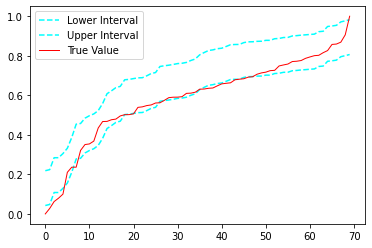

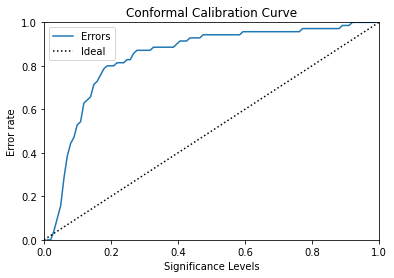

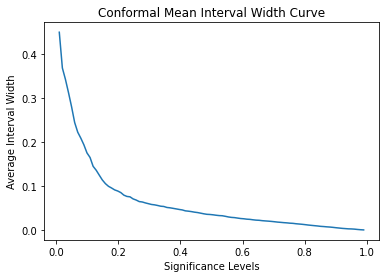

[0.45018456394741, 0.36898920134607205, 0.34304610569925575, 0.31280447306904713, 0.28072418989935777, 0.2450584031399774, 0.22307774551395054, 0.20952303639875747, 0.19440155268240522, 0.17605588429121743, 0.1656613270234566, 0.1455965787181981, 0.1366706981963557, 0.12550559493434577, 0.11450584448175993, 0.10621047459414545, 0.10011988946136063, 0.09628333865392791, 0.09199284298802413, 0.0894544833443871, 0.08589442851452667, 0.08005651664345503, 0.07710337438915404, 0.07621688042205843, 0.0715208350048695, 0.06891738582060647, 0.06544482043691913, 0.06450319958340822, 0.06238949349350631, 0.06064168486470445, 0.05886029136869597, 0.05798627391725408, 0.056546592069482315, 0.0548934889567807, 0.05429878197404636, 0.05205367864753252, 0.051281663173945224, 0.050069718461024815, 0.04882820530916043, 0.047530631073021024, 0.04644854058351666, 0.04436693202137976, 0.043615617155684516, 0.04262523973964294, 0.04135202985215569, 0.04045695569622043, 0.039060609914994826, 0.03765503459883

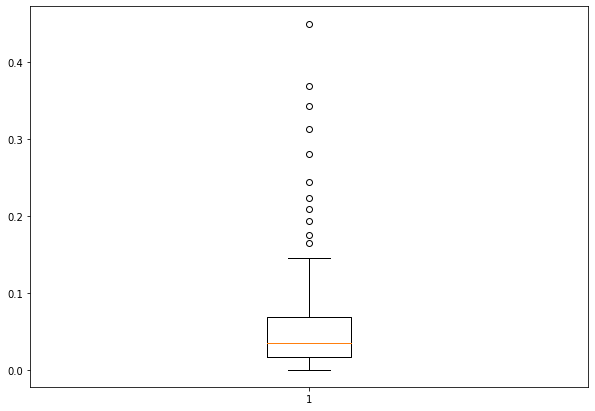

------------------Passing Naru Data----------------------------
---------------Significance - 0.01-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.341499  0.061679  0.341499  0.621319       True
1   0.000000   0.076859 -0.202962  0.076859  0.356679       True
2   0.079539   0.186434 -0.093386  0.186434  0.466254       True
3   0.027687   0.138323 -0.141497  0.138323  0.418143       True
4   0.467319   0.462444  0.182624  0.462444  0.742265       True
5   0.758201   0.767441  0.487620  0.767441  1.047261       True
6   0.678612   0.697064  0.417244  0.697064  0.976884       True
7   0.802396   0.813498  0.533678  0.813498  1.093319       True
8   0.551293   0.555517  0.275696  0.555517  0.835337       True
9   0.476456   0.478516  0.198696  0.478516  0.758337       True
10  0.593186   0.598084  0.318264  0.598084  0.877904       True
11  0.647900   0.632771  0.352951  0.632771  0.912591       True
12  0.590756   0.573194  0.293373  0.57

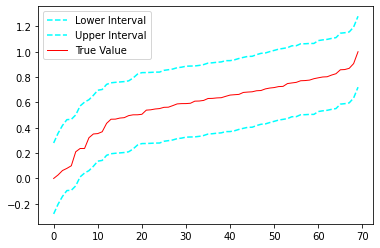

---------------Significance - 0.05-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.341499  0.202597  0.341499  0.480401       True
1   0.000000   0.076859 -0.062044  0.076859  0.215761       True
2   0.079539   0.186434  0.047532  0.186434  0.325336       True
3   0.027687   0.138323 -0.000579  0.138323  0.277225       True
4   0.467319   0.462444  0.323542  0.462444  0.601347       True
5   0.758201   0.767441  0.628538  0.767441  0.906343       True
6   0.678612   0.697064  0.558162  0.697064  0.835966       True
7   0.802396   0.813498  0.674596  0.813498  0.952401       True
8   0.551293   0.555517  0.416614  0.555517  0.694419       True
9   0.476456   0.478516  0.339614  0.478516  0.617419       True
10  0.593186   0.598084  0.459182  0.598084  0.736986       True
11  0.647900   0.632771  0.493869  0.632771  0.771673       True
12  0.590756   0.573194  0.434291  0.573194  0.712096       True
13  0.681524   0.675357  0.536455  0.6

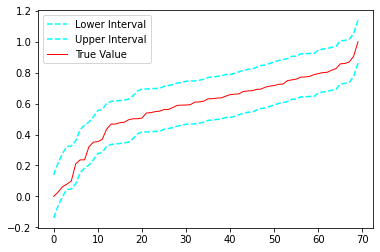

---------------Significance - 0.1-----------------
        True  Predicted     Lower       Mid     Upper  In_bounds
0   0.210529   0.341499  0.242359  0.341499  0.440639      False
1   0.000000   0.076859 -0.022282  0.076859  0.175999       True
2   0.079539   0.186434  0.087294  0.186434  0.285574      False
3   0.027687   0.138323  0.039183  0.138323  0.237463      False
4   0.467319   0.462444  0.363304  0.462444  0.561585       True
5   0.758201   0.767441  0.668300  0.767441  0.866581       True
6   0.678612   0.697064  0.597924  0.697064  0.796204       True
7   0.802396   0.813498  0.714358  0.813498  0.912639       True
8   0.551293   0.555517  0.456376  0.555517  0.654657       True
9   0.476456   0.478516  0.379376  0.478516  0.577657       True
10  0.593186   0.598084  0.498944  0.598084  0.697224       True
11  0.647900   0.632771  0.533631  0.632771  0.731911       True
12  0.590756   0.573194  0.474053  0.573194  0.672334       True
13  0.681524   0.675357  0.576217  0.67

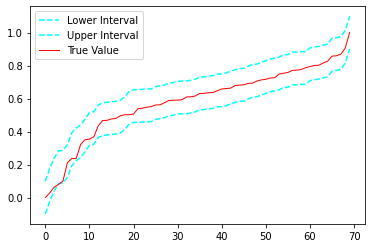

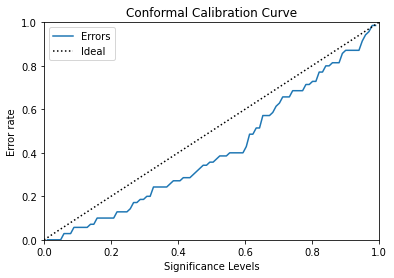

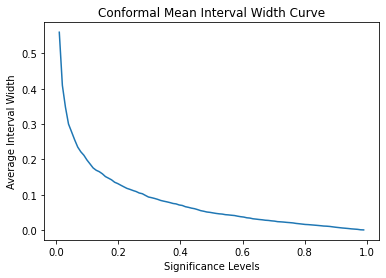

[0.5596406232625786, 0.40956260092074204, 0.3477815729796534, 0.2999839436092946, 0.2778044744167553, 0.2553139477093409, 0.23479264363386676, 0.22148516209426417, 0.2116914880618832, 0.19828042381703415, 0.18714571649941614, 0.17591462069158337, 0.16929267683719362, 0.16526148735650814, 0.15930963178772894, 0.15144689413976975, 0.14686943215829795, 0.14216566585925738, 0.13536931628859472, 0.13166147486191626, 0.1269739180837819, 0.12242929784301615, 0.11800148377746078, 0.11513936925544899, 0.11190823667293293, 0.10907262118124139, 0.1049351149034008, 0.1029314580710079, 0.09820184198087212, 0.09361684125898706, 0.09175196110892747, 0.08954405262640242, 0.08695958567627349, 0.08382937253108302, 0.08176066608439347, 0.07991264910422147, 0.07780889868912011, 0.07533317314677812, 0.07408966344485268, 0.07108212367945255, 0.0697072939816541, 0.06624017694542483, 0.06437861694686586, 0.06213890056630911, 0.06051784927493342, 0.05793085139913923, 0.05501807452778862, 0.05329502205581593, 0

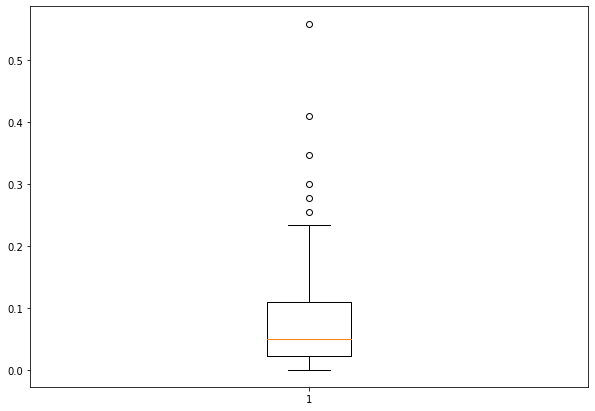

------------------Passing MSCN Bayes Data----------------------------
---------------Significance - 0.01-----------------
       True  Predicted    Lower      Mid    Upper  In_bounds
0   0.32948    0.35888  0.07304  0.35888  0.64472       True
1   0.11015    0.21417 -0.07167  0.21417  0.50001       True
2   0.19301    0.20775 -0.07809  0.20775  0.49359       True
3   0.13899    0.30207  0.01623  0.30207  0.58791       True
4   0.59699    0.58470  0.29886  0.58470  0.87054       True
5   0.90003    0.90894  0.62310  0.90894  1.19478       True
6   0.81712    0.85412  0.56828  0.85412  1.13996       True
7   0.94607    0.96753  0.68169  0.96753  1.25337       True
8   0.68448    0.65376  0.36792  0.65376  0.93960       True
9   0.60651    0.62911  0.34327  0.62911  0.91495       True
10  0.72812    0.68002  0.39418  0.68002  0.96586       True
11  0.78512    0.72755  0.44171  0.72755  1.01339       True
12  0.72559    0.70555  0.41971  0.70555  0.99139       True
13  0.82015    0.75248  

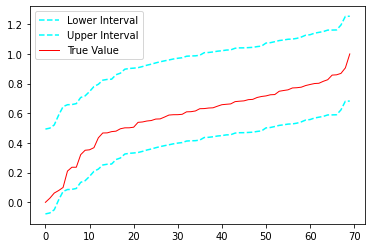

---------------Significance - 0.05-----------------
       True  Predicted    Lower      Mid    Upper  In_bounds
0   0.32948    0.35888  0.18219  0.35888  0.53557       True
1   0.11015    0.21417  0.03748  0.21417  0.39086       True
2   0.19301    0.20775  0.03106  0.20775  0.38444       True
3   0.13899    0.30207  0.12538  0.30207  0.47876       True
4   0.59699    0.58470  0.40801  0.58470  0.76139       True
5   0.90003    0.90894  0.73225  0.90894  1.08563       True
6   0.81712    0.85412  0.67743  0.85412  1.03081       True
7   0.94607    0.96753  0.79084  0.96753  1.14422       True
8   0.68448    0.65376  0.47707  0.65376  0.83045       True
9   0.60651    0.62911  0.45242  0.62911  0.80580       True
10  0.72812    0.68002  0.50333  0.68002  0.85671       True
11  0.78512    0.72755  0.55086  0.72755  0.90424       True
12  0.72559    0.70555  0.52886  0.70555  0.88224       True
13  0.82015    0.75248  0.57579  0.75248  0.92917       True
14  0.35643    0.37934  0.20265  

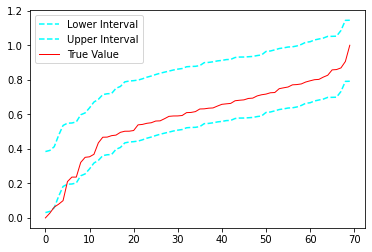

---------------Significance - 0.1-----------------
       True  Predicted    Lower      Mid    Upper  In_bounds
0   0.32948    0.35888  0.24540  0.35888  0.47236       True
1   0.11015    0.21417  0.10069  0.21417  0.32765       True
2   0.19301    0.20775  0.09427  0.20775  0.32123       True
3   0.13899    0.30207  0.18859  0.30207  0.41555      False
4   0.59699    0.58470  0.47122  0.58470  0.69818       True
5   0.90003    0.90894  0.79546  0.90894  1.02242       True
6   0.81712    0.85412  0.74064  0.85412  0.96760       True
7   0.94607    0.96753  0.85405  0.96753  1.08101       True
8   0.68448    0.65376  0.54028  0.65376  0.76724       True
9   0.60651    0.62911  0.51563  0.62911  0.74259       True
10  0.72812    0.68002  0.56654  0.68002  0.79350       True
11  0.78512    0.72755  0.61407  0.72755  0.84103       True
12  0.72559    0.70555  0.59207  0.70555  0.81903       True
13  0.82015    0.75248  0.63900  0.75248  0.86596       True
14  0.35643    0.37934  0.26586  0

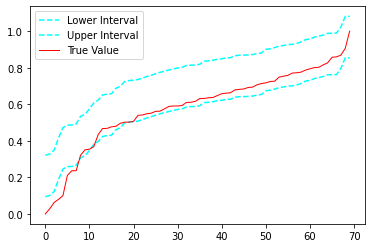

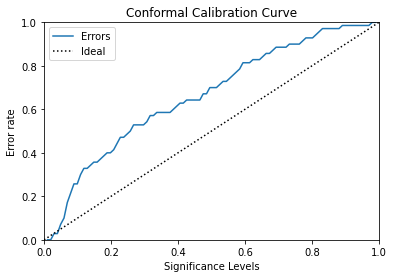

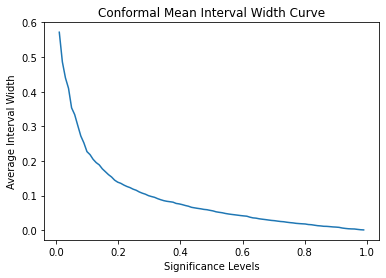

[0.57168, 0.48608000000000007, 0.43989999999999996, 0.4098, 0.35338, 0.3340000000000001, 0.30268000000000006, 0.27205999999999997, 0.2521199999999999, 0.22696000000000005, 0.21829999999999994, 0.20476000000000005, 0.19526, 0.18866000000000005, 0.1772600000000002, 0.16891999999999996, 0.16054000000000013, 0.15372000000000008, 0.14457999999999993, 0.1387799999999999, 0.13546000000000014, 0.13041999999999998, 0.12629999999999986, 0.12308000000000008, 0.11860000000000004, 0.1154599999999999, 0.11062000000000016, 0.10695999999999994, 0.10404000000000013, 0.09987999999999997, 0.09724, 0.09497999999999984, 0.09114, 0.08806000000000003, 0.0853600000000001, 0.08352000000000004, 0.08229999999999982, 0.08099999999999996, 0.07738, 0.07601999999999998, 0.0739399999999999, 0.07138, 0.06932000000000005, 0.06616, 0.06462000000000012, 0.0631400000000002, 0.06188000000000016, 0.0601799999999999, 0.05926000000000009, 0.057439999999999936, 0.05580000000000007, 0.053180000000000005, 0.05171999999999999, 0.

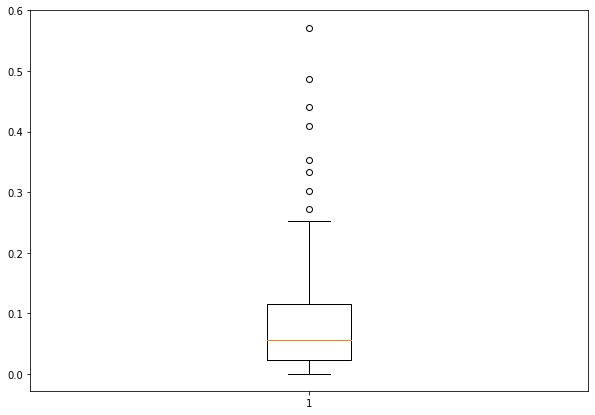

In [ ]:
print("------------------Passing MSCN Data----------------------------")
intervals_MSCN, coverage_MSCN = ConformalPrediction(train_preds_mscn, calib_preds_mscn, test_preds_mscn, 'MSCN')
print("------------------Passing Naru Data----------------------------")
intervals_Naru, coverage_Naru = ConformalPrediction(train_preds_Naru, calib_preds_Naru, test_preds_Naru, 'Naru')
print("------------------Passing MSCN Bayes Data----------------------------")
intervals_MSCN_Bayes, coverage_MSCN_Bayes = ConformalPrediction(train_preds_mscn_bayes, calib_preds_mscn_bayes, test_preds_mscn_bayes, 'MSCN_BNN')

##Ensemble Implementation

###load the intervals of each architecture here

In [ ]:
intervals_ConfMSCN = pd.DataFrame(intervals_MSCN)
intervals_ConfNaru = pd.DataFrame(intervals_Naru)
intervals_ConfMSCNBayes = pd.DataFrame(intervals_MSCN_Bayes)
intervals_BayesMSCN = pd.read_csv('intervals_MSCN_Bayes.csv', header=None)
print(intervals_BayesMSCN)


           0         1
0   0.013967  0.983469
1   0.022197  0.980090
2   0.015635  0.984207
3   0.016812  0.978991
4   0.019336  0.977416
5   0.017730  0.971030
6   0.014933  0.980613
7   0.018564  0.976302
8   0.020940  0.978996
9   0.021347  0.968865
10  0.016331  0.978085
11  0.018225  0.982122
12  0.023545  0.975027
13  0.019877  0.973561
14  0.024639  0.979734
15  0.016983  0.986567
16  0.015970  0.977278
17  0.024118  0.973898
18  0.014596  0.975103
19  0.019862  0.977625
20  0.015423  0.969056
21  0.022842  0.985522
22  0.020395  0.986861
23  0.020830  0.984025
24  0.019147  0.977356
25  0.022740  0.983005
26  0.017568  0.973751
27  0.021543  0.977169
28  0.021647  0.973805
29  0.014791  0.980321
30  0.020500  0.978546
31  0.026631  0.978154
32  0.015450  0.979816
33  0.018475  0.980410
34  0.015659  0.983400
35  0.018941  0.975652
36  0.028235  0.976449
37  0.023030  0.981377
38  0.028605  0.978122
39  0.019351  0.973938
40  0.027508  0.979368
41  0.016758  0.979754
42  0.01313

In [ ]:
def width(interval):
  width = np.abs(interval.iloc[0]-interval.iloc[1])
  return width

def ensemble():
  all_widths = pd.DataFrame(columns=['ConfMSCN', 'ConfNaru', 'ConfMSCNBNN',
                                     'BayesMSCN', 'Min'])
  for i in range(len(test_preds_mscn)):
      all_widths.loc[i,'ConfMSCN'] = width(intervals_ConfMSCN.iloc[i])
      all_widths.loc[i,'ConfNaru'] = width(intervals_ConfNaru.iloc[i])
      all_widths.loc[i,'ConfMSCNBNN'] = width(intervals_ConfMSCNBayes.iloc[i])
      all_widths.loc[i,'BayesMSCN'] = width(intervals_BayesMSCN.iloc[i])
      # all_widths.loc[i,'BayesNaru'] = width(intervals_BayesNaru.iloc[i])
      # all_widths.loc[i,'DeepDB'] = width(intervals_DeepDB.iloc[i])
  return all_widths.astype(float)

In [ ]:
#Loading the normalised test predictions
# test_preds_normalised = np.genfromtxt('normalised_true_test.csv')
test_preds_normalised = np.genfromtxt('normalised_test_true_naru.csv')

In [ ]:
all_widths = ensemble()
all_widths['Min'] = all_widths.idxmin(axis=1)
print("Printing the widths of test instances out of all architectures")
print("---------------------------------------------------------------")
# print(all_widths)
# print("90 = 0.913 , 0.95 = 0.941 and,0.99 = 0.90")

Printing the widths of test instances out of all architectures
---------------------------------------------------------------


In [ ]:
list1 = [coverage_MSCN, coverage_Naru, coverage_MSCN_Bayes]
max_coverage = max(list1)
max_coverage_index=list1.index(max_coverage)
print(max_coverage_index)

for index, row in all_widths.iterrows():
    if row['Min'] == 'ConfMSCN':
      if not max_coverage_index == 0:
        if max_coverage_index == 1 and abs(round(row['ConfMSCN'],2) - round(row['ConfNaru'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfNaru'
        if max_coverage_index == 2 and abs(round(row['ConfMSCN'],2) - round(row['ConfMSCNBNN'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfMSCNBNN'
    if row['Min'] == 'ConfNaru':
      if not max_coverage_index == 1:
        if max_coverage_index == 0 and abs(round(row['ConfNaru'],2) - round(row['ConfMSCN'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfMSCN'
        if max_coverage_index == 2 and abs(round(row['ConfNaru'],2) - round(row['ConfMSCNBNN'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfMSCNBNN'
    if row['Min'] == 'ConfMSCNBNN':
      if not max_coverage_index == 2:
        if max_coverage_index == 0 and abs(round(row['ConfMSCNBNN'],2) - round(row['ConfMSCN'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfMSCN'
        if max_coverage_index == 1 and abs(round(row['ConfMSCNBNN'],2) - round(row['ConfNaru'],2)) <= 0.10:
          all_widths.at[index,'Min'] = 'ConfNaru'
print(all_widths)

1
    ConfMSCN  ConfNaru  ConfMSCNBNN  BayesMSCN       Min
0   0.001035  0.000525       0.0009   0.969502  ConfNaru
1   0.001035  0.000525       0.0009   0.957893  ConfNaru
2   0.001035  0.000525       0.0009   0.968572  ConfNaru
3   0.001035  0.000525       0.0009   0.962179  ConfNaru
4   0.001035  0.000525       0.0009   0.958080  ConfNaru
5   0.001035  0.000525       0.0009   0.953300  ConfNaru
6   0.001035  0.000525       0.0009   0.965680  ConfNaru
7   0.001035  0.000525       0.0009   0.957738  ConfNaru
8   0.001035  0.000525       0.0009   0.958056  ConfNaru
9   0.001035  0.000525       0.0009   0.947518  ConfNaru
10  0.001035  0.000525       0.0009   0.961753  ConfNaru
11  0.001035  0.000525       0.0009   0.963897  ConfNaru
12  0.001035  0.000525       0.0009   0.951482  ConfNaru
13  0.001035  0.000525       0.0009   0.953683  ConfNaru
14  0.001035  0.000525       0.0009   0.955095  ConfNaru
15  0.001035  0.000525       0.0009   0.969584  ConfNaru
16  0.001035  0.000525       

In [ ]:
#Retrieving intervals of ensemble after identifying the tighter widths
ensemble_intervals = pd.DataFrame()
for index, row in all_widths.iterrows():
    if row['Min'] == 'ConfMSCN':
      ensemble_intervals = ensemble_intervals.append(intervals_ConfMSCN.iloc[index], ignore_index=True)
    if row['Min'] == 'ConfNaru':
      ensemble_intervals = ensemble_intervals.append(intervals_ConfNaru.iloc[index], ignore_index=True)
    if row['Min'] == 'ConfMSCNBNN':
      ensemble_intervals = ensemble_intervals.append(intervals_ConfMSCNBayes.iloc[index], ignore_index=True)
    if row['Min'] == 'BayesMSCN':
      ensemble_intervals = ensemble_intervals.append(intervals_BayesMSCN.iloc[index], ignore_index=True)

print("--------------------------Ensemble Intervals---------------------------")
ensemble_intervals = ensemble_intervals.to_numpy(copy=True, dtype='float64')
print(ensemble_intervals)

--------------------------Ensemble Intervals---------------------------
[[0.341236 0.341762]
 [0.076596 0.077121]
 [0.186171 0.186697]
 [0.138060 0.138586]
 [0.462182 0.462707]
 [0.767178 0.767703]
 [0.696801 0.697327]
 [0.813236 0.813761]
 [0.555254 0.555779]
 [0.478254 0.478779]
 [0.597821 0.598347]
 [0.632508 0.633034]
 [0.572931 0.573456]
 [0.675094 0.675620]
 [0.221058 0.221584]
 [0.484177 0.484702]
 [-0.000263 0.000263]
 [0.291925 0.292450]
 [0.785063 0.785588]
 [0.593612 0.594138]
 [0.489998 0.490523]
 [0.630033 0.630559]
 [0.682883 0.683408]
 [0.649233 0.649759]
 [0.558947 0.559472]
 [0.606678 0.607204]
 [0.558824 0.559349]
 [0.639381 0.639906]
 [0.607422 0.607947]
 [0.745734 0.746259]
 [0.322144 0.322670]
 [0.375562 0.376087]
 [0.740105 0.740630]
 [0.416030 0.416556]
 [0.183953 0.184479]
 [0.474597 0.475122]
 [0.636569 0.637094]
 [0.512089 0.512615]
 [0.649535 0.650061]
 [0.577639 0.578165]
 [0.866027 0.866553]
 [0.824809 0.825334]
 [0.876011 0.876536]
 [0.655809 0.656335]
 [0

Ensemble Coverage - 1.00
Ensemble Mean width - 0.00
Ensemble Error rate - 0.99
Ensemble Coverage rate - 0.01
----------------Final Ensemble Plot-------------------


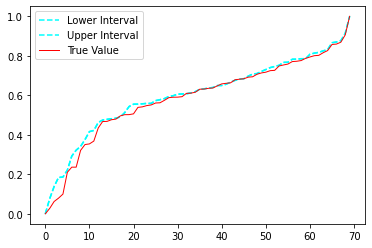

In [ ]:
ens_mean_width, ens_errorRate, ens_coverage = pValues2PerfMetrics(
            ensemble_intervals, test_preds_normalised
            )
print("Ensemble Coverage - {0:.2f}".format(ens_coverage))
print("Ensemble Mean width - {0:.2f}".format(ens_mean_width))
print("Ensemble Error rate - {0:.2f}".format(ens_errorRate))
print("Ensemble Coverage rate - {0:.2f}".format(1-ens_errorRate))
print("----------------Final Ensemble Plot-------------------")
final_plot(ensemble_intervals, test_preds_normalised)